In [1]:
#Подгружаем необходимые библиотеки для работы с данными и машинного обучения
import warnings
import timeit

import pandas as pd

import catboost
import phik
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import (LinearRegression, 
                                  Ridge, 
                                  Lasso,
                                  ElasticNet)
from catboost import CatBoostRegressor
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             mean_absolute_percentage_error,
                             f1_score,
                             r2_score,
                             roc_curve, 
                             roc_auc_score, 
                             confusion_matrix,
                             accuracy_score,
                             make_scorer)
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.dummy import DummyRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats as st
from statsmodels.tsa.seasonal import seasonal_decompose

#Подгружаем дополнительные полезные библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#Уберем warnings, чтобы не мешали
warnings.filterwarnings("ignore")

In [3]:
#Загружаем файлы с данными
data_train = pd.read_csv('C:/Users/kiril/OneDrive/Рабочий стол/Хакатон/train_dataset.csv',
                         index_col=[0], 
                         parse_dates=[0])
data_test = pd.read_csv('C:/Users/kiril/OneDrive/Рабочий стол/Хакатон/test_dataset.csv',
                         index_col=[0], 
                         parse_dates=[0])

In [4]:
#Проверяем датафреймы
data_train.head(5)

,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер
2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер
2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер
2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм"
2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм"


In [5]:
data_test.head(5)

,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2023-04-01,0,479.282,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01,1,445.182,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01,2,424.225,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01,3,413.866,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
2023-04-01,4,408.146,5.0,4.0,"пасм, 71% дождь","пасм, дымка"


In [6]:
data_train['time'] = pd.to_datetime(data_train.index.astype(str) + ':' + data_train['time'].astype(str), format='%Y-%m-%d:%H')
data_train = data_train.set_index('time') 
data_test['time'] = pd.to_datetime(data_test.index.astype(str) + ':' + data_test['time'].astype(str), format='%Y-%m-%d:%H')
data_test = data_test.set_index('time') 

In [7]:
#Выведем инфо о датафреймах
data_train.info(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37224 entries, 2019-01-01 00:00:00 to 2023-03-31 23:00:00
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   target        37224 non-null  float64
 1   temp          37224 non-null  float64
 2   temp_pred     37136 non-null  float64
 3   weather_pred  37136 non-null  object 
 4   weather_fact  37223 non-null  object 
dtypes: float64(3), object(2)
memory usage: 1.7+ MB


In [8]:
data_test.info(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2928 entries, 2023-04-01 00:00:00 to 2023-07-31 23:00:00
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   target        2928 non-null   float64
 1   temp          2928 non-null   float64
 2   temp_pred     2904 non-null   float64
 3   weather_pred  2904 non-null   object 
 4   weather_fact  2928 non-null   object 
dtypes: float64(3), object(2)
memory usage: 137.2+ KB


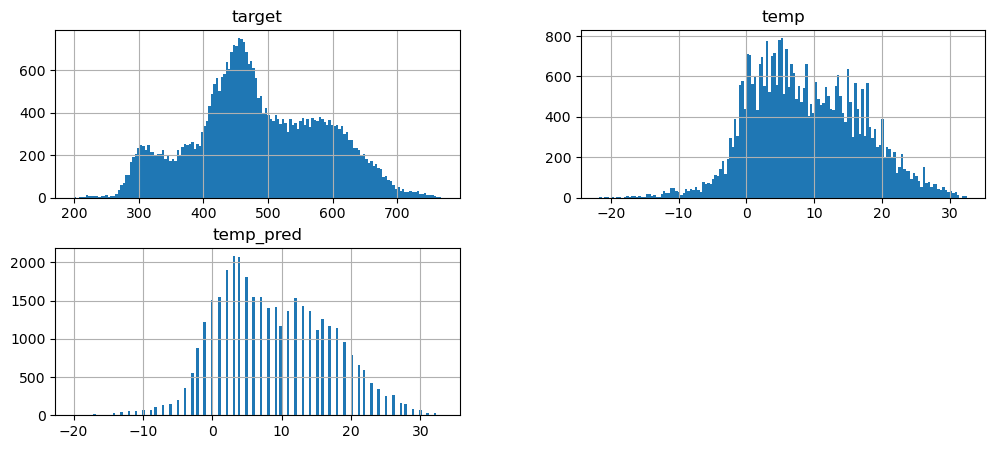

In [9]:
#Построим гистограммы
data_train.hist(figsize=(12,5), bins=150);

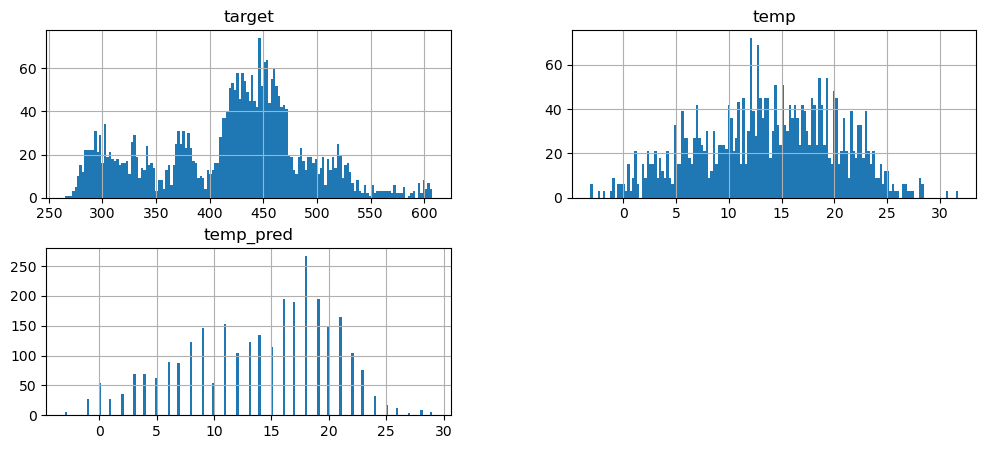

In [10]:
data_test.hist(figsize=(12,5), bins=150);

In [11]:
#Выведем описание датафрейма
data_train.describe().transpose().round(3)

,count,mean,std,min,25%,50%,75%,max
target,37224.0,483.731,101.459,198.982,418.951,473.064,561.217,767.888
temp,37224.0,8.749,8.126,-21.700,2.600,7.900,14.700,32.500
temp_pred,37136.0,8.769,8.018,-20.000,3.000,8.000,15.000,33.000


In [12]:
data_test.describe().transpose().round(3)

,count,mean,std,min,25%,50%,75%,max
target,2928.0,419.467,71.393,264.819,371.384,431.477,462.414,607.474
temp,2928.0,13.769,6.480,-3.100,9.200,14.000,18.700,31.700
temp_pred,2904.0,13.910,6.382,-3.000,9.000,15.000,19.000,29.000


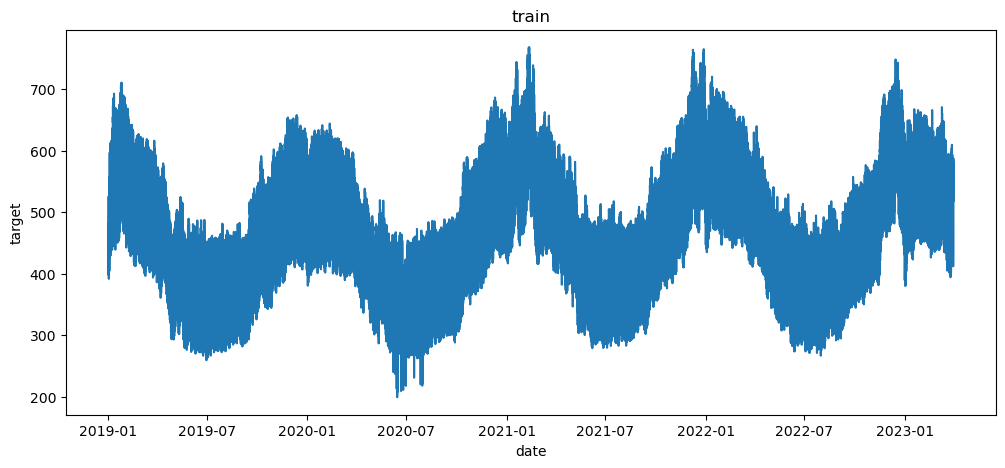

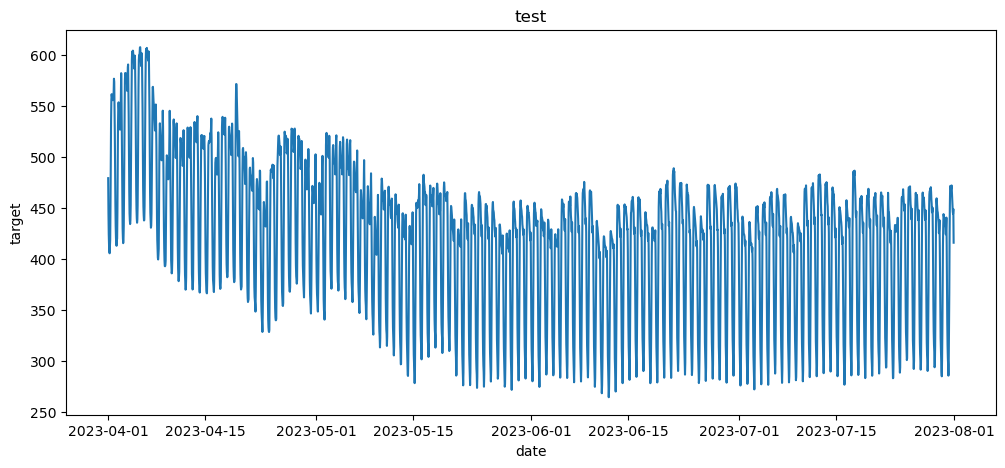

In [13]:
#Выполним сортирову данных
data_train.sort_index(inplace=True)
data_test.sort_index(inplace=True)

#Построим график для временного ряда
plt.figure(figsize=(12,5))
plt.plot(data_train['target'])
plt.title('train')
plt.xlabel('date');
plt.ylabel('target');

plt.figure(figsize=(12,5))
plt.plot(data_test['target'])
plt.title('test')
plt.xlabel('date');
plt.ylabel('target');

In [14]:
#Выведем уникальные значения категориальных признаков 
len(data_train['weather_pred'].unique())

2182

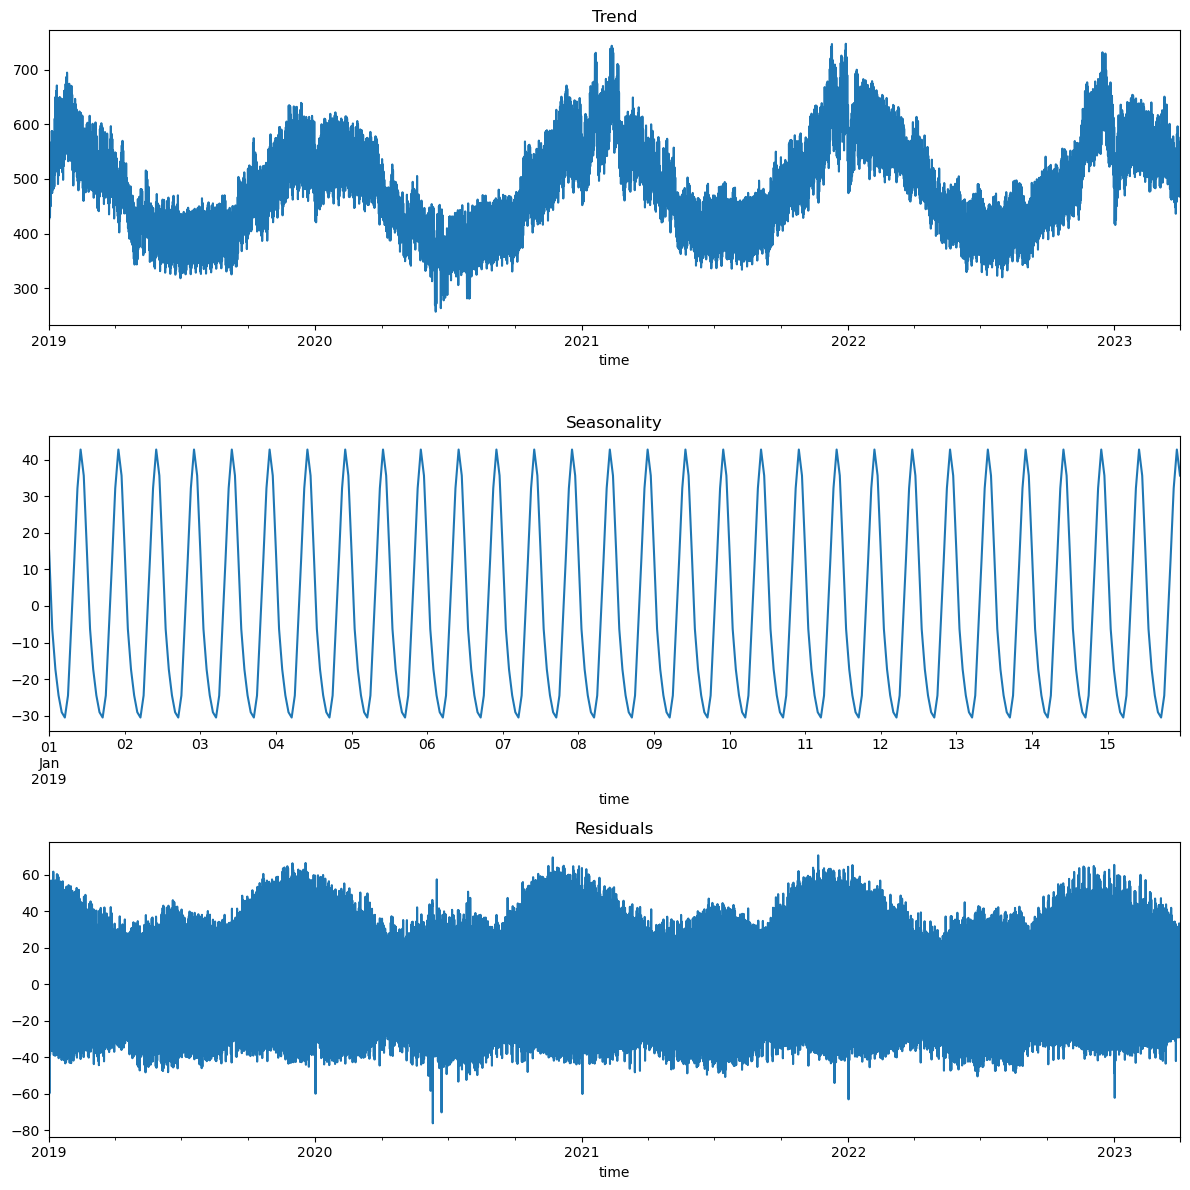

In [15]:
#Проверим на тренды и сезонность временной ряд
decomposed = seasonal_decompose(data_train['target'], period=12)
plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

#Сезонность проверим для интервала в 1 год
plt.subplot(312)
decomposed.seasonal['2019-01-01':'2019-01-15'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

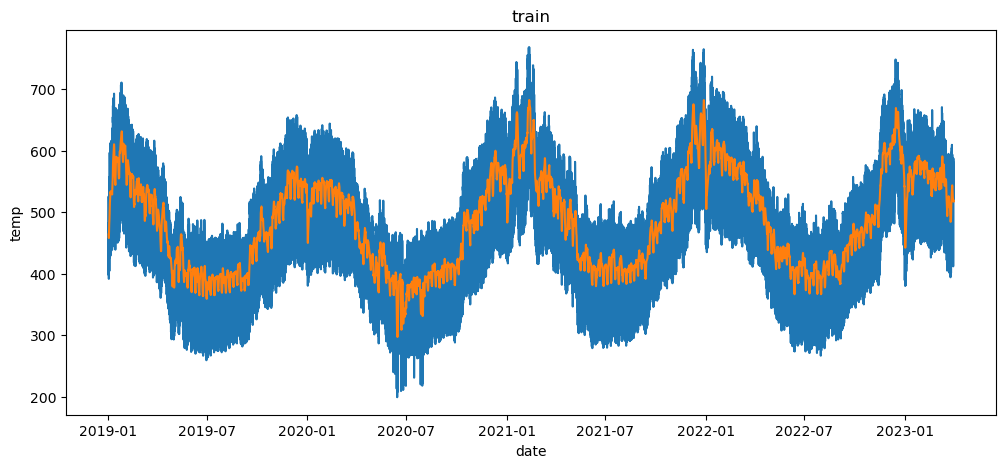

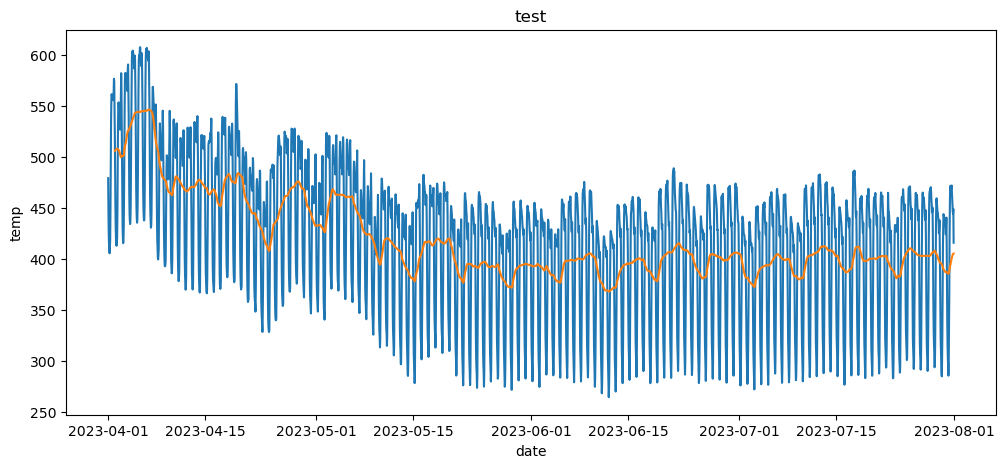

In [16]:
#Построим график скользящего среднего для тренировочной выборки
plt.figure(figsize=(12,5))
plt.plot(data_train['target'])
plt.plot(data_train['target'].rolling(24).mean())
plt.title('train')
plt.xlabel('date');
plt.ylabel('temp');

#Построим график скользящего среднего для тестовой выборки
plt.figure(figsize=(12,5))
plt.plot(data_test['target'])
plt.plot(data_test['target'].rolling(24).mean())
plt.title('test')
plt.xlabel('date');
plt.ylabel('temp');

,target,temp,temp_pred,weather_pred,weather_fact
time,,,,,
2021-02-17 00:00:00,568.658,-4.0,NaN,NaN,облачно
2021-02-17 03:00:00,504.264,-6.0,NaN,NaN,облачно
2021-02-17 06:00:00,521.233,-10.0,NaN,NaN,облачно
2021-02-17 09:00:00,665.486,-9.0,NaN,NaN,облачно
2021-02-17 12:00:00,702.568,-5.0,NaN,NaN,облачно
...,...,...,...,...,...
2022-10-04 09:00:00,495.988,14.2,NaN,NaN,пер.обл.
2022-10-04 12:00:00,529.651,13.6,NaN,NaN,пер.обл.
2022-10-04 15:00:00,514.598,13.4,NaN,NaN,пер.обл.


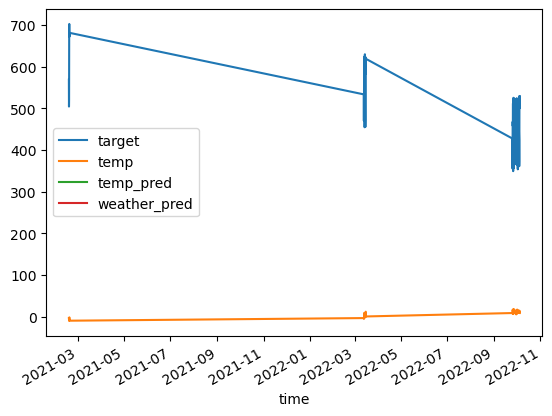

In [17]:
#Рассмотрим, где есть пропуски
data_train.loc[data_train['temp_pred'].isna() == True].plot()
data_train.loc[data_train['temp_pred'].isna() == True]

In [18]:
#Подготавливаем выборку для заполнения пропусков
data_train_for_isna = data_train.copy()
data_train_for_isna['year'] = data_train_for_isna.index.year
data_train_for_isna['month'] = data_train_for_isna.index.month
data_train_for_isna['dayofweek'] = data_train_for_isna.index.dayofweek
data_train_for_isna['day'] = data_train_for_isna.index.day
data_train_for_isna['hour'] = data_train_for_isna.index.hour
data_train_for_isna.head()

,target,temp,temp_pred,weather_pred,weather_fact,year,month,dayofweek,day,hour
time,,,,,,,,,,
2019-01-01 00:00:00,481.510,2.9,2.0,"пасм, ветер",ветер,2019,1,1,1,0
2019-01-01 01:00:00,462.872,2.9,2.0,"пасм, ветер",ветер,2019,1,1,1,1
2019-01-01 02:00:00,449.718,2.9,2.0,"пасм, ветер",ветер,2019,1,1,1,2
2019-01-01 03:00:00,430.908,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,1,3
2019-01-01 04:00:00,415.163,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,1,4


In [19]:
#Посмотрим, в какие годы, месяцы, дни и часы пропуски
print('Годы:', data_train_for_isna.loc[data_train['temp_pred'].isna() == True, 'year'].unique())
print('Месяцы:', data_train_for_isna.loc[data_train['temp_pred'].isna() == True, 'month'].unique())
print('Дни:', data_train_for_isna.loc[data_train['temp_pred'].isna() == True, 'day'].unique())
print('Часы:', data_train_for_isna.loc[data_train['temp_pred'].isna() == True, 'hour'].unique())

Годы: [2021 2022]
Месяцы: [ 2  3  9 10]
Дни: [17 13 14 15 25 26 27 30  1  2  4]
Часы: [ 0  3  6  9 12 15 18 21]


In [20]:
#Посмотрим на 1 месяц с пропущенной температурой
data_train_for_isna.loc[(data_train_for_isna['year'] == 2022) 
                        & (data_train_for_isna['month'] == 9)
                        & (data_train_for_isna['day'] == 30)
                       ]

,target,temp,temp_pred,weather_pred,weather_fact,year,month,dayofweek,day,hour
time,,,,,,,,,,
2022-09-30 00:00:00,431.912,5.7,NaN,NaN,"ясно, холодно",2022,9,4,30,0
2022-09-30 01:00:00,397.170,5.7,0.0,0,"ясно, холодно",2022,9,4,30,1
2022-09-30 02:00:00,377.082,5.7,0.0,0,"ясно, холодно",2022,9,4,30,2
2022-09-30 03:00:00,365.584,5.1,NaN,NaN,"ясно, холодно",2022,9,4,30,3
2022-09-30 04:00:00,360.539,5.1,0.0,0,"ясно, холодно",2022,9,4,30,4
2022-09-30 05:00:00,363.924,5.1,0.0,0,"ясно, холодно",2022,9,4,30,5
2022-09-30 06:00:00,382.436,6.6,NaN,NaN,"дымка, прохладно",2022,9,4,30,6
2022-09-30 07:00:00,417.896,6.6,0.0,0,"дымка, прохладно",2022,9,4,30,7
2022-09-30 08:00:00,459.536,6.6,0.0,0,"дымка, прохладно",2022,9,4,30,8


In [21]:
#Cтранно, прогноза погоды вообще нет
#Посмотрим как дела обстоят с остальными данными, где есть пропуски
data_train_for_isna['date'] = data_train_for_isna.index
data_train_for_isna['date'] = data_train_for_isna['date'].dt.date
list_dates_train = list(data_train_for_isna.loc[data_train_for_isna['temp_pred'].isna() == True,'date'].astype(str).unique())
list_dates_train

['2021-02-17',
 '2022-03-13',
 '2022-03-14',
 '2022-03-15',
 '2022-09-25',
 '2022-09-26',
 '2022-09-27',
 '2022-09-30',
 '2022-10-01',
 '2022-10-02',
 '2022-10-04']

<AxesSubplot:xlabel='time'>

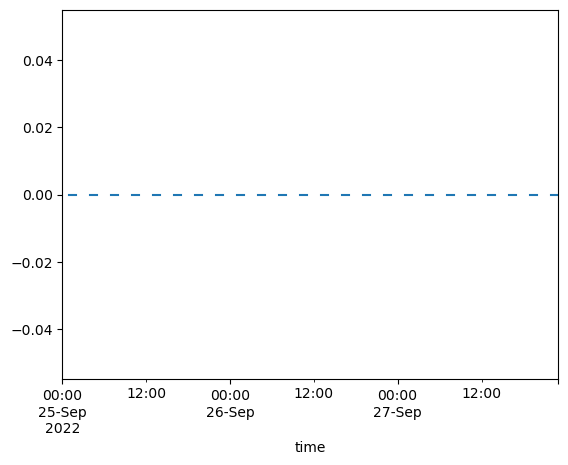

In [22]:
data_train_for_isna['2022-09-25':'2022-09-27']['temp_pred'].plot()

In [23]:
#Логика ясна, temp_pred и weather_pred в определенные даты просто либо отсутствуют, либо равны 0
#Проверим, что с тестовой выборкой
data_test_for_isna = data_test.copy()
data_test_for_isna['year'] = data_test_for_isna.index.year
data_test_for_isna['month'] = data_test_for_isna.index.month
data_test_for_isna['dayofweek'] = data_test_for_isna.index.dayofweek
data_test_for_isna['day'] = data_test_for_isna.index.day
data_test_for_isna['hour'] = data_test_for_isna.index.hour

print('Годы:', data_test_for_isna.loc[data_test['temp_pred'].isna() == True, 'year'].unique())
print('Месяцы:', data_test_for_isna.loc[data_test['temp_pred'].isna() == True, 'month'].unique())
print('Дни:', data_test_for_isna.loc[data_test['temp_pred'].isna() == True, 'day'].unique())
print('Часы:', data_test_for_isna.loc[data_test['temp_pred'].isna() == True, 'hour'].unique())

Годы: [2023]
Месяцы: [6]
Дни: [7 8 9]
Часы: [ 0  3  6  9 12 15 18 21]


In [24]:
data_test_for_isna['date'] = data_test_for_isna.index
data_test_for_isna['date'] = data_test_for_isna['date'].dt.date
list_dates_test = list(data_test_for_isna.loc[data_test_for_isna['temp_pred'].isna() == True,'date'].astype(str).unique())
list_dates_test

['2023-06-07', '2023-06-08', '2023-06-09']

<AxesSubplot:xlabel='time'>

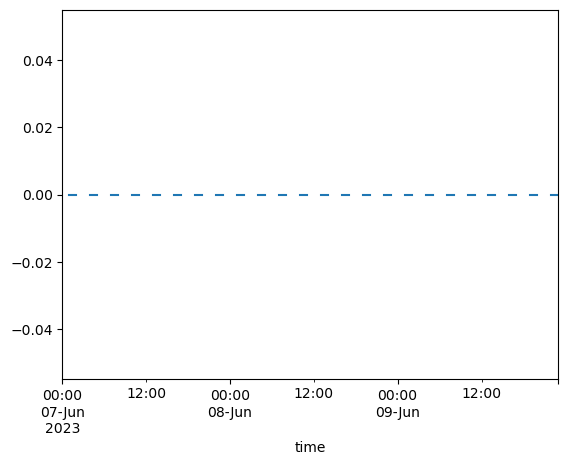

In [25]:
data_test_for_isna['2023-06-07':'2023-06-09']['temp_pred'].plot()

In [26]:
#Заменим пропуски и 0 в датах с пропусками на реальную температуру
data_train_1 = data_train.copy()
data_test_1 = data_test.copy()
for i in list_dates_train:
    data_train_1.loc[i, 'temp_pred'] = data_train_for_isna.loc[i, 'temp']
    data_train_1.loc[i, 'weather_pred'] = data_train_for_isna.loc[i, 'weather_fact']
for i in list_dates_test:
    data_test_1.loc[i, 'temp_pred'] = data_test_for_isna.loc[i, 'temp']
    data_test_1.loc[i, 'weather_pred'] = data_test_for_isna.loc[i, 'weather_fact']

In [27]:
data_train_1.head()

,target,temp,temp_pred,weather_pred,weather_fact
time,,,,,
2019-01-01 00:00:00,481.510,2.9,2.0,"пасм, ветер",ветер
2019-01-01 01:00:00,462.872,2.9,2.0,"пасм, ветер",ветер
2019-01-01 02:00:00,449.718,2.9,2.0,"пасм, ветер",ветер
2019-01-01 03:00:00,430.908,4.3,2.0,"пасм, ветер","ветер, пасм"
2019-01-01 04:00:00,415.163,4.3,2.0,"пасм, ветер","ветер, пасм"


In [28]:
data_test_1.head()

,target,temp,temp_pred,weather_pred,weather_fact
time,,,,,
2023-04-01 00:00:00,479.282,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 01:00:00,445.182,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 02:00:00,424.225,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 03:00:00,413.866,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
2023-04-01 04:00:00,408.146,5.0,4.0,"пасм, 71% дождь","пасм, дымка"


In [29]:
data_train_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37224 entries, 2019-01-01 00:00:00 to 2023-03-31 23:00:00
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   target        37224 non-null  float64
 1   temp          37224 non-null  float64
 2   temp_pred     37224 non-null  float64
 3   weather_pred  37224 non-null  object 
 4   weather_fact  37223 non-null  object 
dtypes: float64(3), object(2)
memory usage: 2.7+ MB


In [30]:
data_test_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2928 entries, 2023-04-01 00:00:00 to 2023-07-31 23:00:00
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   target        2928 non-null   float64
 1   temp          2928 non-null   float64
 2   temp_pred     2928 non-null   float64
 3   weather_pred  2928 non-null   object 
 4   weather_fact  2928 non-null   object 
dtypes: float64(3), object(2)
memory usage: 201.8+ KB


In [31]:
#Делаем ресемплинг по 1 дню
data_resample_train = data_train_1.copy()
data_resample_test = data_test_1.copy()

data_resample_train = data_resample_train.drop(['weather_fact', 'weather_pred'], axis=1)
data_resample_test = data_resample_test.drop(['weather_fact', 'weather_pred'], axis=1)

data_resample_train['target'] = data_resample_train['target'].resample('1D').sum()
data_resample_train['temp'] = data_resample_train['temp'].resample('1D').mean()
data_resample_train['temp_pred'] = data_resample_train['temp_pred'].resample('1D').mean()

data_resample_test['target'] = data_resample_test['target'].resample('1D').sum()
data_resample_test['temp'] = data_resample_test['temp'].resample('1D').mean()
data_resample_test['temp_pred'] = data_resample_test['temp_pred'].resample('1D').mean()

data_resample_train = data_resample_train.dropna()
data_resample_test = data_resample_test.dropna()

data_resample_train.head()

,target,temp,temp_pred
time,,,
2019-01-01,11126.866,4.8750,4.375
2019-01-02,11547.210,1.3500,1.500
2019-01-03,12235.564,-1.1625,-1.375
2019-01-04,12763.044,-1.5000,-0.125
2019-01-05,12735.145,0.9375,1.500


In [32]:
#Подготавливаем обучающую выборку
#Сдвигаем целевое значение на одну дату вверх, т.к. модель должна уметь прогнозировать энергопотребление завтрашнего дня,
#соответственно оно будет целевым на сегодняшний день
#Сдвигаем прогноз погоды также на одну дату вверх, так как мы о нем можем знать только вчера
data_train_shift = data_resample_train.copy()
data_train_shift['target'] = data_resample_train['target'].shift(-1)
data_train_shift['temp_pred'] = data_resample_train['temp_pred'].shift(-1)
data_train_shift = data_train_shift.dropna()
data_train_shift.head()

,target,temp,temp_pred
time,,,
2019-01-01,11547.210,4.8750,1.500
2019-01-02,12235.564,1.3500,-1.375
2019-01-03,12763.044,-1.1625,-0.125
2019-01-04,12735.145,-1.5000,1.500
2019-01-05,12744.419,0.9375,-3.750


In [33]:
data_train_dig = data_train_shift.copy()

In [34]:
#Сначала напишем функцию для создания признаков
def make_features(data_1, max_lag, rolling_mean_size):
    data_for_model = data_1.copy()
    data_for_model['year'] = data_for_model.index.year
    data_for_model['month'] = data_for_model.index.month
    data_for_model['day'] = data_for_model.index.day
    data_for_model['dayofweek'] = data_for_model.index.dayofweek
    
    for i in range(1, max_lag + 1):
        data_for_model[f'lag_{i}'] = data_for_model['target'].shift(i)

    data_for_model['rolling_mean'] = data_for_model['lag_1'].rolling(rolling_mean_size).mean()
    data_for_model = data_for_model.dropna()
    features = data_for_model.drop('target', axis=1)
    target = data_for_model['target']
    return features, target

In [35]:
features, target = make_features(data_train_dig, 
                                 4, 
                                 10)
features.head()

,temp,temp_pred,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean
time,,,,,,,,,,,
2019-01-11,-3.2000,0.750,2019,1,11,4,14606.295,14339.844,13949.530,13185.565,13082.6551
2019-01-12,1.4250,2.125,2019,1,12,5,13522.839,14606.295,14339.844,13949.530,13280.2180
2019-01-13,2.6500,1.125,2019,1,13,6,13138.749,13522.839,14606.295,14339.844,13370.5365
2019-01-14,1.2125,-0.125,2019,1,14,0,13922.957,13138.749,13522.839,14606.295,13486.5278
2019-01-15,1.1750,1.750,2019,1,15,1,14138.603,13922.957,13138.749,13522.839,13626.8736


In [36]:
target.head()

time
2019-01-11    13522.839
2019-01-12    13138.749
2019-01-13    13922.957
2019-01-14    14138.603
2019-01-15    14048.604
Name: target, dtype: float64

In [37]:
best_score_set = []

In [38]:
best_score_DT = 1000000
#Применим функции для создания признаков и разбиения на выборки
for max_lag in range(2, 5):
    for rolling_mean_size in range(10, 60, 10):
        features_train, target_train = make_features(data_train_dig, 
                                                     max_lag, 
                                                     rolling_mean_size)
        
        #Используем DecisionTreeRegressor вместе с RandomizedSearchCV
        DT = DecisionTreeRegressor(random_state=12345)
        
        rs_space={'max_depth':[None] + [i for i in range(2, 7)]}
        
        tscv = TimeSeriesSplit(n_splits=5)
        
        DT_random = RandomizedSearchCV(DT, rs_space, n_iter=100, scoring='neg_mean_absolute_error', cv=tscv)
        model_random = DT_random.fit(features_train, target_train)
        
        score = (-1) * round(model_random.best_score_, 3)
        
        if score < best_score_DT:  
            best_score_DT = score
            best_model_DT = model_random.best_estimator_
            best_params_DT = model_random.best_params_
            max_lag_DT = max_lag
            rolling_mean_size_DT = rolling_mean_size
    
best_score_set.append(best_score_DT)
    
print(20 * '-')
print('Для DT:')
print('Лучшая модель:', best_model_DT)
print('Лучшие гиперпараметры:', best_params_DT)
print('Лучший MAE:', best_score_DT)
print(f'Лучший лаг и окно: {max_lag_DT} и {rolling_mean_size_DT}')

--------------------
Для DT:
Лучшая модель: DecisionTreeRegressor(max_depth=6, random_state=12345)
Лучшие гиперпараметры: {'max_depth': 6}
Лучший MAE: 316.665
Лучший лаг и окно: 2 и 30


In [39]:
best_score_LGBM = 1000000
#Применим функции для создания признаков и разбиения на выборки
for max_lag in range(2, 10):
    for rolling_mean_size in range(10, 60, 10):
        features_train, target_train = make_features(data_train_dig, 
                                                     max_lag, 
                                                     rolling_mean_size)
        
        #Используем LightGBM вместе с RandomizedSearchCV
        LGBM = lgb.LGBMRegressor(verbose=-1, n_jobs=-1, random_state=12345)
        
        rs_space={'max_depth':([None] + [i for i in range(2, 7)]),
                  'n_estimators':np.arange(10, 500, 50),
                 }
        
        tscv = TimeSeriesSplit(n_splits=5)
        
        LGBM_random = RandomizedSearchCV(LGBM, rs_space, n_iter=100, scoring='neg_mean_absolute_error', cv=tscv)
        model_random = LGBM_random.fit(features_train, target_train)
        
        score = (-1) * round(model_random.best_score_, 3)
        
        if score < best_score_LGBM:  
            best_score_LGBM = score
            best_model_LGBM = model_random.best_estimator_
            best_params_LGBM = model_random.best_params_
            max_lag_LGBM = max_lag
            rolling_mean_size_LGBM = rolling_mean_size
    
best_score_set.append(best_score_LGBM)
    
print(20 * '-')
print('Для LGBM:')
print('Лучшая модель:', best_model_LGBM)
print('Лучшие гиперпараметры:', best_params_LGBM)
print('Лучший MAE:', best_score_LGBM)
print(f'Лучший лаг и окно: {max_lag_LGBM} и {rolling_mean_size_LGBM}')

--------------------
Для LGBM:
Лучшая модель: LGBMRegressor(max_depth=2, n_estimators=260, random_state=12345, verbose=-1)
Лучшие гиперпараметры: {'n_estimators': 260, 'max_depth': 2}
Лучший MAE: 213.249
Лучший лаг и окно: 3 и 10


In [40]:
#Объединяем обучающую и тестовую выборку, чтобы при сдвиге признаков у тестовой выборки были все значения
data_train_test = pd.concat([data_resample_train, data_resample_test])

#Подготавливаем данные для тестовой выборки
data_train_test_shift = data_train_test.copy()
data_train_test_shift['target'] = data_train_test_shift['target'].shift(-1)
data_train_test_shift['temp_pred'] = data_train_test_shift['temp_pred'].shift(-1)

data_train_test_shift = data_train_test_shift.dropna()
data_train_test_dig = data_train_test_shift.copy()

data_train_test_dig.head()

,target,temp,temp_pred
time,,,
2019-01-01,11547.210,4.8750,1.500
2019-01-02,12235.564,1.3500,-1.375
2019-01-03,12763.044,-1.1625,-0.125
2019-01-04,12735.145,-1.5000,1.500
2019-01-05,12744.419,0.9375,-3.750


--------------------
MAE тестовой выборки: 137.208
MAPE тестовой выборки: 0.013
R2 тестовой выборки: 0.957


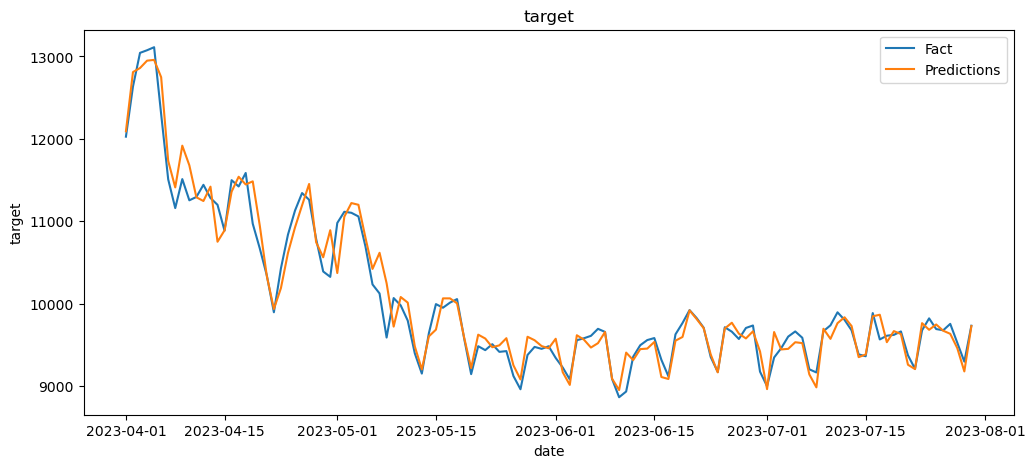

In [41]:
#Проверим на тестовой выборке lgbm
features_train_test, target_train_test = make_features(data_train_test_dig, max_lag_LGBM, rolling_mean_size_LGBM)
features_test = features_train_test['2023-04-01':'2023-08-01']
target_test = target_train_test['2023-04-01':'2023-08-01']
features_train, target_train = make_features(data_train_dig, max_lag_LGBM, rolling_mean_size_LGBM)

model = best_model_LGBM
model.fit(features_train, target_train)
predictions = model.predict(features_test)
mae_test = mean_absolute_error(target_test, predictions)
mape_test = mean_absolute_percentage_error(target_test, predictions)
r2_test = r2_score(target_test, predictions)
print('-' * 20)
print('MAE тестовой выборки:', round(mae_test, 3))
print('MAPE тестовой выборки:', round(mape_test, 3))
print('R2 тестовой выборки:', round(r2_test, 3))

#Построим график для временного ряда
prediction = pd.DataFrame({'MAE' : predictions}, index=target_test.index)
plt.figure(figsize=(12,5))
plt.plot(target_test, label='Fact')
plt.plot(prediction, label='Predictions')
plt.title('target')
plt.xlabel('date');
plt.ylabel('target');
plt.legend();

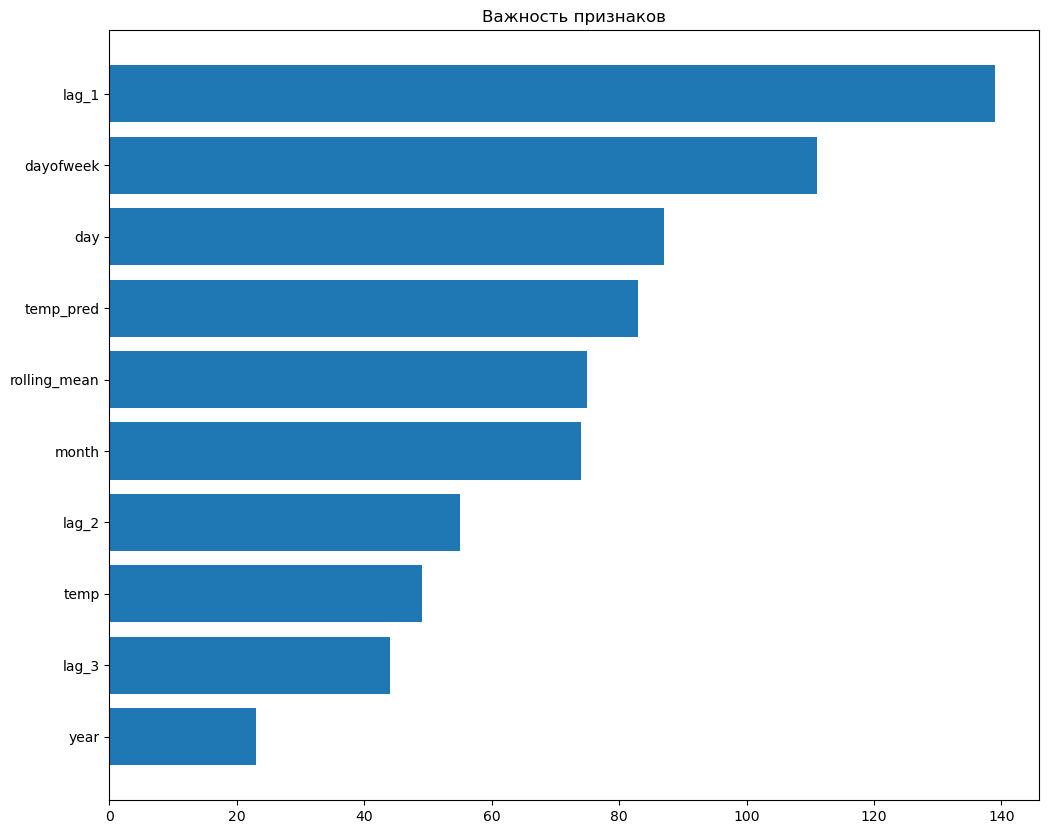

In [42]:
#Построим график важности признаков
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center');
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx]);
plt.title('Важность признаков');